In [1]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import pandas as pd

In [2]:
class Data(Dataset):
    def __init__(self, x, y):
        super().__init__()
        self.x = torch.from_numpy(x.values).float()
        self.y = torch.from_numpy(y.values).float()
    def __len__(self):
        return self.x.shape[0]
    def __getitem__(self, index):
        x, y = self.x[index], self.y[index]
        return x, y

xtrain, ytrain, xtest, ytest = pd.read_csv('./xtrain.csv', header= None, index_col = None), pd.read_csv('./ytrain.csv', header = None, index_col = None), pd.read_csv('./xval.csv', header = None, index_col = None), pd.read_csv('./yval.csv', header = None, index_col = None)
train_data = Data(x= xtrain, y= ytrain)
test_data = Data(x= xtest, y= ytest)
train_loader = DataLoader(train_data, batch_size=100, shuffle= True)
test_loader = DataLoader(test_data, batch_size= 100)

In [3]:
class LinearModel(nn.Module):
    def __init__(self, p=0.2):
        super().__init__()
        self.feature = nn.Sequential(
            nn.Linear(in_features=65, out_features=40, bias=True),
            nn.ReLU(),
            nn.BatchNorm1d(40),
            nn.Linear(in_features=40, out_features=35, bias=True),
            nn.ReLU(),
            nn.BatchNorm1d(35),
            nn.Linear(in_features=35, out_features=30, bias=True),
            nn.ReLU(),
            nn.BatchNorm1d(30),
            nn.Dropout(p=p),
            nn.Linear(in_features=30, out_features=25, bias=True),
            nn.ReLU(),
            nn.BatchNorm1d(25),
            nn.Linear(in_features=25, out_features=20, bias=True),
            nn.ReLU(),
            nn.BatchNorm1d(20),
            nn.Linear(in_features= 20, out_features= 10, bias= True),
            nn.ReLU(),
            nn.BatchNorm1d(10),
            nn.Linear(in_features= 10, out_features= 5, bias= True),
            nn.ReLU(),
            nn.BatchNorm1d(5)
        )
        self.classifier = nn.Sequential(
            nn.Linear(in_features=5, out_features=1, bias=True),
            nn.Sigmoid()
        )
        self.feature.apply(self.init_weights)
        
    def forward(self, x):
        return self.classifier(self.feature(x))
    
    @staticmethod
    def init_weights(m):
        if isinstance(m, nn.Linear):
            # He initialization for ReLU
            nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)

In [4]:
model = LinearModel(p = 0.2)
model = model.to('cuda')
criterion = nn.BCELoss()

In [5]:
optimizer = torch.optim.Adam(model.parameters(), lr= 0.001, weight_decay= 0.0001)
# checkpoint = torch.load('relumodel1.pt')
# model.load_state_dict(checkpoint)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer= optimizer, mode= 'min', factor= 0.5, patience= 10)

In [6]:
loss_list_train, loss_list_val = [], []
for epoch in range(600):
    model.train()
    running_loss_trian, running_loss_val = 0.0, 0.0
    for input, target in train_loader:
        input, target = input.to('cuda'), target.to('cuda')
        optimizer.zero_grad()
        output = model(input)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        running_loss_trian += loss.item()
    model.eval()
    with torch.no_grad():
        for input, target in test_loader:
            input, target = input.to('cuda'), target.to('cuda')
            output = model(input)
            loss = criterion(output, target)
            running_loss_val += loss.item()
    scheduler.step(running_loss_val / len(test_loader))
    loss_list_train.append(running_loss_trian / len(train_loader))
    loss_list_val.append(running_loss_val / len(test_loader))
    print(f'Epoch - {epoch} loss - {running_loss_trian}')

Epoch - 0 loss - 3427.905074417591
Epoch - 1 loss - 2974.8285090625286
Epoch - 2 loss - 2711.1126793324947
Epoch - 3 loss - 2542.390894755721
Epoch - 4 loss - 2397.4385407567024
Epoch - 5 loss - 2285.1863817572594
Epoch - 6 loss - 2196.943432584405
Epoch - 7 loss - 2125.5680789351463
Epoch - 8 loss - 2071.4993733912706
Epoch - 9 loss - 2023.5383301079273
Epoch - 10 loss - 1992.674200847745
Epoch - 11 loss - 1965.959688887
Epoch - 12 loss - 1938.8372061699629
Epoch - 13 loss - 1913.6099159121513
Epoch - 14 loss - 1900.2305394858122
Epoch - 15 loss - 1893.836919978261
Epoch - 16 loss - 1872.1403537541628
Epoch - 17 loss - 1853.7660176232457
Epoch - 18 loss - 1841.0071106404066
Epoch - 19 loss - 1837.19642560184
Epoch - 20 loss - 1822.3557435944676
Epoch - 21 loss - 1818.3226223438978
Epoch - 22 loss - 1808.1641094088554
Epoch - 23 loss - 1809.8254097402096
Epoch - 24 loss - 1795.6119656935334
Epoch - 25 loss - 1786.4520033076406
Epoch - 26 loss - 1781.2630174309015
Epoch - 27 loss - 1642

In [7]:
# total 600 epochs done

In [8]:
import pandas as pd

# loss_list_t = pd.read_csv("train_loss_relu1.csv").values.flatten().tolist()
loss_list_t = []
loss_list_train = loss_list_t + loss_list_train
df = pd.DataFrame(loss_list_train)
df.to_csv("train_loss_relu1.csv", index=False, header= False)
# loss_list_t = pd.read_csv("test_loss_relu1.csv").values.flatten().tolist()
loss_list_t = []
loss_list_val = loss_list_t + loss_list_val
df = pd.DataFrame(loss_list_val)
df.to_csv("test_loss_relu1.csv", index= False, header= False)


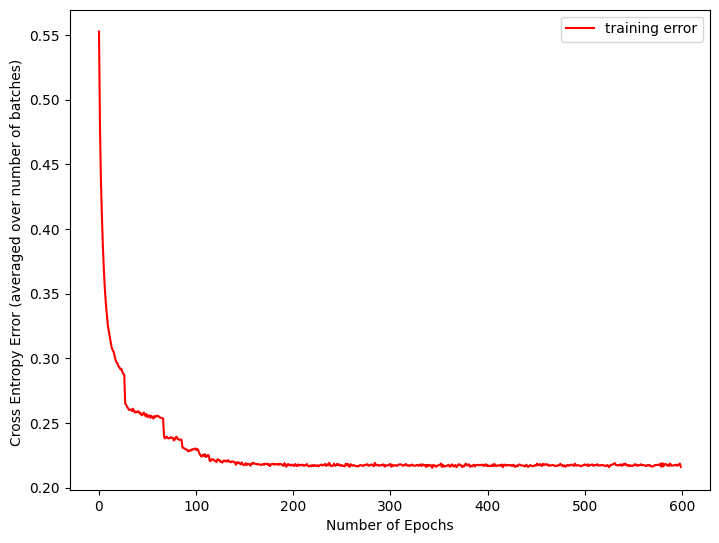

In [9]:
from matplotlib import pyplot as plt
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
plt.plot(range(len(loss_list_train)), loss_list_train, color= 'red', label = 'training error')
# plt.plot(range(len(loss_list_val)), loss_list_val, color = 'blue', label = 'validation error')
plt.xlabel('Number of Epochs')
plt.ylabel('Cross Entropy Error (averaged over number of batches) ')
plt.legend()
plt.show()

In [10]:
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for input, target in test_loader:
        input, target = input.to('cuda'), target.to('cuda')
        output = torch.round(model(input))
        all_preds.extend(output.to('cpu'))
        all_labels.extend(target.to('cpu'))

from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
print(accuracy_score(all_preds, all_labels))
print(recall_score(all_labels, all_preds))
print(precision_score(all_labels, all_preds))
print(f1_score(all_labels, all_preds))

0.955596270948968
0.9915067336117498
0.9021818026557363
0.9447375480640258


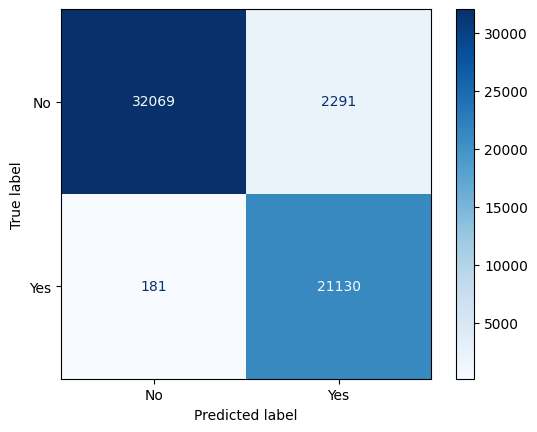

In [11]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Example: y_true and y_pred are your ground truth and predictions
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels= ['No', 'Yes'])
disp.plot(cmap='Blues')
plt.show()


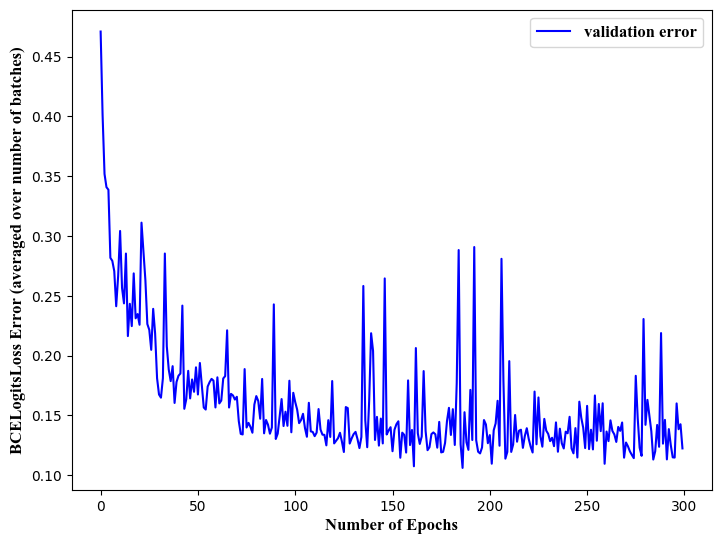

In [7]:
from matplotlib import pyplot as plt
import pandas as pd

# Load loss data
loss_list_train = pd.read_csv("train_loss_relu1.csv").values.flatten().tolist()[: 300]
loss_list_test = pd.read_csv("test_loss_relu1.csv").values.flatten().tolist()[: 300]

# Create figure
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])

# Plotting
# plt.plot(range(len(loss_list_train)), loss_list_train, color='red', label='training error')
plt.plot(range(len(loss_list_test)), loss_list_test, color='blue', label='validation error')

# Label styling
font = {'family': 'Times New Roman', 'weight': 'bold', 'size': 12}
plt.xlabel('Number of Epochs', fontdict=font)
plt.ylabel('BCELogitsLoss Error (averaged over number of batches)', fontdict=font)

# Legend styling
plt.legend(prop={'family': 'Times New Roman', 'weight': 'bold', 'size': 12})

# Show plot
plt.show()


In [13]:
torch.save(model.state_dict(), 'relumodel1.pt')

C:\Users\Suchit\AppData\Local\Temp\2\ipykernel_29220\1484256784.py:40: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', n_models)


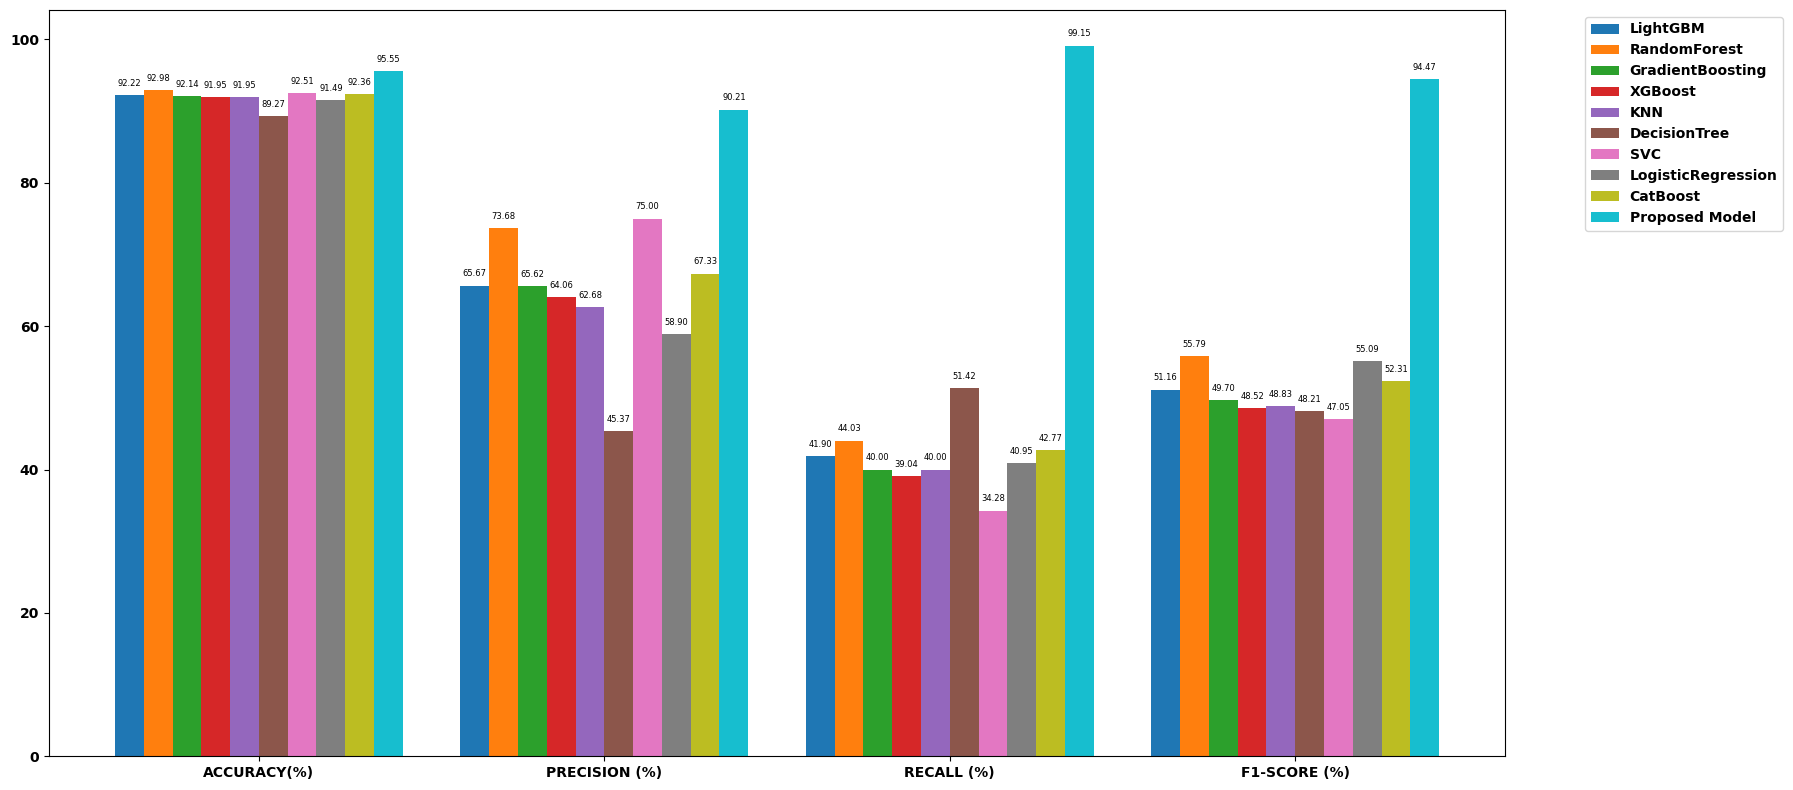

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl

# Data
data = {
    'LightGBM': [92.22, 65.67, 41.90, 51.16],
    'RandomForest': [92.98, 73.68, 44.03, 55.79],
    'GradientBoosting': [92.14, 65.62, 40.00, 49.70],
    'XGBoost': [91.95, 64.06, 39.04, 48.52],
    'KNN': [91.95, 62.68, 40.00, 48.83],
    'DecisionTree': [89.27, 45.37, 51.42, 48.21],
    'SVC': [92.51, 75.00, 34.28, 47.05],
    'LogisticRegression': [91.49, 58.90, 40.95, 55.09],
    'CatBoost': [92.36, 67.33, 42.77, 52.31],
    'Proposed Model': [95.55, 90.21, 99.15, 94.47]
}

metrics = ['ACCURACY(%)', 'PRECISION (%)', 'RECALL (%)', 'F1-SCORE (%)']

# Convert to DataFrame
df = pd.DataFrame(data, index=metrics)

# Create figure and axes with more width to accommodate gaps
fig, ax = plt.subplots(figsize=(18, 8))

# Get the number of metrics and models
n_metrics = len(metrics)
n_models = len(data)
width = 1  # Width of each bar

# Create x positions for each group with gaps
positions = []
for i in range(n_metrics):
    group_pos = np.arange(n_models) + (i * (n_models + 2))  # Add gap of 2 between metric groups
    positions.append(group_pos)

# Create a colormap with 11 distinct colors
colors = plt.cm.get_cmap('tab10', n_models)
colors = [colors(i) for i in range(n_models)]

# Make all text bold by default
plt.rcParams['font.weight'] = 'bold'
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titleweight'] = 'bold'

# Plot bars for each metric
bars = []
for i, metric in enumerate(metrics):
    for j, (model, color) in enumerate(zip(data.keys(), colors)):
        bar = ax.bar(positions[i][j], df.loc[metric, model], width, color=color, label=model if i == 0 else "")
        # Add value labels with NORMAL weight - explicitly override the global setting
        ax.text(positions[i][j], df.loc[metric, model] + 1, f'{df.loc[metric, model]:.2f}', 
                ha='center', va='bottom', fontsize=6, fontweight='normal')

# Set x-ticks and labels at the center of each group
group_centers = [pos.mean() for pos in positions]
ax.set_xticks(group_centers)
ax.set_xticklabels(metrics, fontweight='bold')

# Add legend outside the plot with bold text
legend = ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Adjust layout
plt.tight_layout()
plt.show()